In [ ]:
pip install deepxde


In [ ]:
pip install tensorflow_addons

DeepXDE backend not selected or invalid. Use tensorflow.compat.v1.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term

Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  total_n_samples))
/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+104=104. 
  total_n_samples))
/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'build' took 0.219541 s

'compile' took 10.036497 s

Initializing variables...
Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.41e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [6.68e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1000      [4.00e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [5.62e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model1.ckpt-1000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
2000      [2.44e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [3.41e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
3000      [1.19e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [1.86e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:model/model1.ckpt-3000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
4000      [5.88e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [7.83e-02, 0

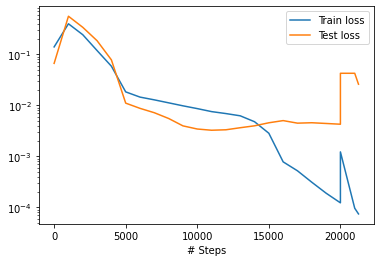

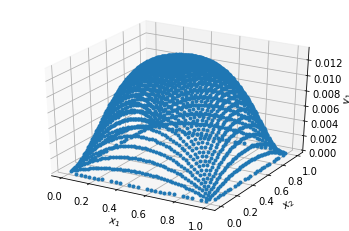

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

import deepxde as dde

import tensorflow_addons as tfa

from tensorflow_addons import activations


from matplotlib import pyplot



p=1.5


def func(x,y):
    # return 2*np.pi*np.pi*tf.sin(np.pi*x) * tf.sin(np.pi*y)
    return 1



def pde(x,y):
     u_x = dde.grad.jacobian(y, x, i=0, j=0) # derivative of the the output wrt first input (x_coor)
     u_y = dde.grad.jacobian(y, x, i=0, j=1) # derivative of the the output wrt second input (y_coor)

     norm_gradu = tf.math.sqrt(u_x**2 + u_y**2 )**(p-2) # It should be scalar

     u_x_norm_grad = u_x * norm_gradu
     u_y_norm_grad = u_y * norm_gradu

     u_x_norm_grad_x = dde.grad.jacobian(u_x_norm_grad, x, i=0, j=0)
     u_y_norm_grad_y = dde.grad.jacobian(u_y_norm_grad, x, i=0, j=1)


     return -(u_x_norm_grad_x+u_y_norm_grad_y) - func(x[:,0:1],x[:,1:2])

def func_bdy(x):
    return np.zeros([len(x),1])

domain = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])

def boundary_b(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)

def boundary_t(x, on_boundary):
    return on_boundary and np.isclose(x[1], 1)

def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)


bc1 = dde.DirichletBC(domain, func_bdy, boundary_b, component=0)
bc2 = dde.DirichletBC(domain, func_bdy, boundary_t, component=0)
bc3 = dde.DirichletBC(domain, func_bdy, boundary_r, component=0)
bc4 = dde.DirichletBC(domain, func_bdy, boundary_l, component=0)

loss_weights = [0.1, 1, 1, 1, 1]
batch_size_ = 256

data = dde.data.PDE(
    domain, pde, [bc1,bc2,bc3,bc4], num_domain=100, num_boundary=100, num_test=2560
)
metrics_=None
net = dde.maps.FNN([2] + [50] * 6 + [1], tfa.activations.snake, "Glorot uniform")
net.apply_output_transform(
        lambda x, y : x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] *(1 - x[:, 1:2])* y )



model = dde.Model(data, net)

model.compile("adam", lr=0.0001, metrics=metrics_,loss='MSE',loss_weights=loss_weights)
checker = dde.callbacks.ModelCheckpoint(
    "model/model1.ckpt", save_better_only=True, period=1000
)
losshistory, train_state = model.train(epochs=20000,batch_size = batch_size_,callbacks = [checker])
model.compile("L-BFGS-B")
losshistory, train_state = model.train(epochs=20000,batch_size = batch_size_)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)












In [ ]:
model.compile("adam", lr=0.0001, metrics=metrics_,loss='MSE',loss_weights=loss_weights)
checker = dde.callbacks.ModelCheckpoint(
    "model/model1.ckpt", save_better_only=True, period=1000
)
losshistory, train_state = model.train(epochs=500000,batch_size = batch_size_,callbacks = [checker])

Compiling model...
'compile' took 7.128039 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
50147     [1.10e-05, 2.84e-04, 2.75e-05, 4.22e-05, 1.74e-05]    [2.88e-05, 2.84e-04, 2.75e-05, 4.22e-05, 1.74e-05]    []  
51000     [4.98e-05, 2.35e-04, 1.82e-05, 2.80e-05, 1.63e-05]    [9.76e-05, 2.35e-04, 1.82e-05, 2.80e-05, 1.63e-05]    []  
INFO:tensorflow:model/model1.ckpt-51147.ckpt is not in all_model_checkpoint_paths. Manually adding it.
52000     [2.47e-04, 4.25e-04, 1.05e-05, 2.41e-05, 1.26e-05]    [2.22e-04, 4.25e-04, 1.05e-05, 2.41e-05, 1.26e-05]    []  
53000     [5.26e-05, 2.10e-04, 1.45e-05, 2.50e-05, 1.13e-05]    [1.11e-04, 2.10e-04, 1.45e-05, 2.50e-05, 1.13e-05]    []  
INFO:tensorflow:model/model1.ckpt-53147.ckpt is not in all_model_checkpoint_paths. Manually adding it.
54000     [6.15e-03, 1.53e-03, 5.86e-04, 5.77e-04, 2.17e-03]    [7.09e-03, 1.53e-03, 5.86e-04, 5.77e-04, 2.

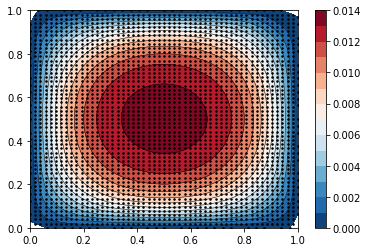

In [ ]:
from matplotlib import pyplot as plt

data = np.genfromtxt("test.dat", delimiter=' ')
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

fig, ax = pyplot.subplots(nrows=1)
ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")

fig.colorbar(cntr, ax=ax)
ax.plot(x, y, 'k.', ms=3)
pyplot.show()

In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin


--2022-07-25 12:38:07--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2831 (2.8K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   2.76K  --.-KB/s    in 0s      

2022-07-25 12:38:07 (28.2 MB/s) - ‘/tmp/fenics-install.sh’ saved [2831/2831]

+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh
+ [[ https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh == http* ]]
+ PYBIND11_

In [ ]:
#! /usr/bin/env python
#
from fenics import *

def p_laplacian ( my_grid, my_degree, my_p ):

#*****************************************************************************80
#
## p_laplacian tries to solve the p-Laplacian problem directly.
#
#  Discussion:
#
#    Solve the nonlinear PDE:
#
#      - div gamma(u) grad u = f in Omega = [0,1]x[0,1]
#                          u = 0 on dOmega
#
#    where:
#
#      gamma(u) = ( epsilon^2 + |grad u|^2) ) ^ ( (p-2)/2 )
#               = ( epsilon^2 + wx^2 + wy^2 ) ^ ( (p-2)/2 )
#
#      epsilon = 1.0E-05
#
#      f(x,y) = 2*pi*pi*sin(pi*x) * sin(pi*y)
#
#    The parameter epsilon artificially keeps gamma(u) bounded above 0,
#    guaranteeing that the power (p-2)/2 is meaningful, and the equation
#    is solvable.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    29 October 2018
#
#  Author:
#
#    John Burkardt
#
#  Reference:
#
#    John Barrett, W B Liu,
#    Finite Element Approximation of the p-Laplacian,
#    Mathematics of Computation,
#    Volume 61, Number 204, pages 423-537, October 1993.
#
#    Patrick Farrell, Hans Petter Langtangen, Marie Rognes, Garth Wells,
#    Implementing finite element models in Python/FEniCS:
#    steady nonlinear PDEs,
#    MMSC: Python in Scientific Computing,
#    May 6, 2015
#
#  Parameters:
#
#    Input, integer MY_GRID, the number of (pairs of) elements to use in the
#    X and Y directions.  Number of triangular elements is 2*my_grid*my_grid.
#
#    Input, integer MY_DEGREE, specifies approximation degree for the solution.
#
#    Input, real MY_P, the desired value of the p exponent in the equation.
#    2 represents the usual Laplacian.
#    0 < P < 2 will involve dividing by the norm of the gradient, which will
#    result in a large coefficient anywhere near a solution extremum,
#    and (if epsilon were 0) an unbounded value at an extremum.
#
  import matplotlib.pyplot as plt
  import numpy as np
#
#  Report input.
#
  print ( '' )
  print ( '  Case of %d x %d mesh' % ( my_grid, my_grid ) )
  print ( '  Approximation degree %d:' % ( my_degree ) )
  print ( '  P-Laplacian parameter P = %g' % ( my_p ) )
#
#  Mesh the unit square.
#  If we don't use the "crossed" option, then two corner triangles are entirely 0.
#
  my_mesh = UnitSquareMesh ( my_grid, my_grid, 'crossed' )
#
#  Plot the mesh.
#
  plot ( my_mesh, title = 'p_laplacian Mesh' )
  filename = 'p_laplacian_mesh.png'
  plt.savefig ( filename )
  print ( '  Graphics saved as "%s"' % ( filename ) )
  plt.close ( )
#
#  Define the function space.
#
  V = FunctionSpace ( my_mesh, "Lagrange", my_degree )
#
#  Because this is a nonlinear problem, u is a function, not a trial function!
#  We need to give it an initial value for the Newton iteration.
#  The function here is positive in the interior, and satisfies the boundary conditions.
#
  uexpr = Expression ( "x[0] * ( 1.0 - x[0] ) * x[1] * ( 1.0 - x[1] )", degree = 10 )
  u = interpolate ( uexpr, V )
#
#  v is just a test function.
#
  v = TestFunction ( V )
#
#  Define the right hand side f(x,y):
#
  #f = Expression ( '2 * pi * pi * sin ( pi * x[0] ) * sin ( pi * x[1] )', degree = 10 )
  f = Constant ( 1.0 )
#
#  Define the boundary condition.
#
  g = Constant ( 0.0 )
  bc = DirichletBC ( V, g, DomainBoundary ( ) )
#
#  Define the "diffusivity".
#
  epsilon = Constant ( 1.0e-05 )
  p = Constant ( my_p )

  def gamma ( u ):
    value = ( epsilon ** 2 + inner ( grad ( u ), grad ( u ) ) ) ** ( ( p - 2 ) / 2 )
    return value
#
#  Define the nonlinear function.
#
  F = inner ( grad ( v ), gamma ( u ) * grad ( u ) ) * dx - inner ( f, v ) * dx
#
#  Request a solution.
#
  solve ( F == 0, u, bc )
#
#  Plot the solution u.
#
  fig = plot ( u, title = 'p_laplacian solution' )
  plt.colorbar ( fig )
  filename = 'p_laplacian_solution.png'
  plt.savefig ( filename )
  print ( '  Graphics saved as "%s"' % ( filename ) )
  plt.close ( )
#
#  Plot |grad u|.
#
  gradun = sqrt ( grad ( u ) ** 2 )
  fig = plot ( gradun, title = 'p_laplacian |grad u|' )
  plt.colorbar ( fig )
  filename = 'p_laplacian_gradun.png'
  plt.savefig ( filename )
  print ( '  Graphics saved as "%s"' % ( filename ) )
  plt.close ( )
#
#  Plot gamma(u).
#
  gammau = gamma ( u )
  fig = plot ( gammau, title = 'p_laplacian gamma(u)' )
  plt.colorbar ( fig )
  filename = 'p_laplacian_gammau.png'
  plt.savefig ( filename )
  print ( '  Graphics saved as "%s"' % ( filename ) )
  plt.close ( )

  coords = V.tabulate_dof_coordinates()
  vec = u.vector().get_local()
  outfile = open("output_pLap_elliptic_p15_f1.dat", "w")
  for coord, val in zip(coords, vec):
    print(coord[0], coord[1], val, file=outfile)
#
#  Terminate.
#
  return

def p_laplacian_test ( ):

#*****************************************************************************80
#
## p_laplacian_test tests p_laplacian.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    29 October 2018
#
#  Author:
#
#    John Burkardt
#
  import time

  print ( time.ctime ( time.time() ) )
  print ( '' )
  print ( 'p_laplacian_test:' )
  print ( '  FENICS/Python version' )
  print ( '  Solve the nonlinear p-Laplacian equation directly.' )
#
#  Report level = only warnings or higher.
#
  level = 30
  set_log_level ( level )
#
#  Set input parameters:
#  P = 3.0 means (P-2)/2 is positive.
#  P = 1.5 means (P-2)/2 is negative.
#
  my_grid = 16
  my_degree = 1
  my_p = 1.5

  p_laplacian ( my_grid, my_degree, my_p )
#
#  Terminate.
#
  print ( '' )
  print ( 'p_laplacian_test:' );
  print ( '  Normal end of execution.' )
  print ( '' )
  print ( time.ctime ( time.time() ) )

if ( __name__ == '__main__' ):

  p_laplacian_test ( )

Mon Jul 25 12:41:58 2022

p_laplacian_test:
  FENICS/Python version
  Solve the nonlinear p-Laplacian equation directly.

  Case of 16 x 16 mesh
  Approximation degree 1:
  P-Laplacian parameter P = 1.5
  Graphics saved as "p_laplacian_mesh.png"
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
  Graphics saved as "p_laplacian_solution.png"
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this m

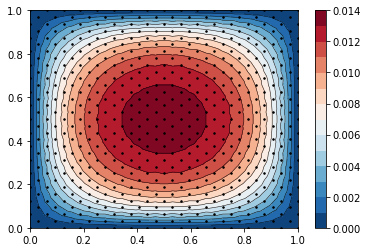

In [ ]:
from matplotlib import pyplot

data = np.genfromtxt("output_pLap_elliptic_p15_f1.dat", delimiter=' ')
xp = data[:, 0]
yp = data[:, 1]
zp = data[:, 2]

fig, ax = pyplot.subplots(nrows=1)
ax.tricontour(xp, yp, zp, levels=14, linewidths=0.5, colors='k')
cntr = ax.tricontourf(xp, yp, zp, levels=14, cmap="RdBu_r")

fig.colorbar(cntr, ax=ax)
ax.plot(xp, yp, 'k.', ms=3)
pyplot.show()

[0.00000000e+00 0.00000000e+00 1.60911324e-04 0.00000000e+00
 0.00000000e+00 1.68518862e-04 3.29013448e-04 1.77349721e-04
 0.00000000e+00 0.00000000e+00 7.43521377e-06 1.50026754e-04
 1.27105508e-04 1.17208576e-04 4.43656463e-05 0.00000000e+00
 0.00000000e+00 6.36861660e-05 5.80614433e-05 4.33763489e-07
 6.44754618e-06 1.02020102e-04 9.40035097e-05 1.81553885e-04
 0.00000000e+00 0.00000000e+00 1.03003345e-04 2.49026343e-05
 4.76166606e-05 1.22147612e-05 1.04111154e-04 1.28477812e-04
 2.29902565e-04 1.50658190e-04 2.07204372e-04 0.00000000e+00
 0.00000000e+00 1.24184415e-04 8.23615119e-06 8.02446157e-05
 1.84522942e-05 8.62199813e-05 8.18683766e-05 1.72072090e-04
 1.57989096e-04 2.27401033e-04 1.07388943e-04 1.84559729e-04
 0.00000000e+00 0.00000000e+00 1.32871093e-04 7.76490197e-06
 9.12663527e-05 1.44494697e-05 7.97286630e-05 4.66145575e-05
 1.07869506e-04 9.43262130e-05 1.60406344e-04 1.05520710e-04
 1.72424596e-04 5.14560379e-05 1.63641758e-04 0.00000000e+00
 0.00000000e+00 1.372438

545

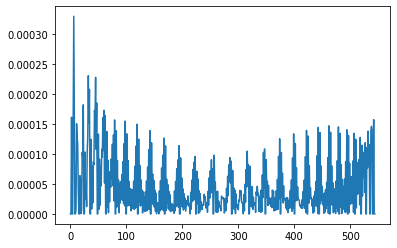

In [ ]:
err2=np.zeros(len(zp))
for i in range(len(zp)):
  err2[i]=np.linalg.norm(zp[i]-model.predict(np.array([[xp[i],yp[i]]])),2)

plt.plot(err2)

print(err2)
len(err2)